In [1]:
import pandas as pd
import csv
import numpy as np

In [2]:
import math

def merc_x(lon):
  r_major=6378137.000
  return r_major*math.radians(lon)

def merc_y(lat):
  if lat>89.5:lat=89.5
  if lat<-89.5:lat=-89.5
  r_major=6378137.000
  r_minor=6356752.3142
  temp=r_minor/r_major
  eccent=math.sqrt(1-temp**2)
  phi=math.radians(lat)
  sinphi=math.sin(phi)
  con=eccent*sinphi
  com=eccent/2
  con=((1.0-con)/(1.0+con))**com
  ts=math.tan((math.pi/2-phi)/2)/con
  y=0-r_major*math.log(ts)
  return y

#Distancia entre dos punto geograficos. Se obtiene sus proyecciones Mercator y la distancia euclidea entre ellas en km
def dist(p1lon,p1lat,p2lon,p2lat):
	x1=merc_x(p1lon)
	x2=merc_x(p2lon)
	y1=merc_y(p1lat)
	y2=merc_y(p2lat)
	return math.sqrt((x1-x2)**2+(y1-y2)**2) / 1000

In [3]:
f = open('../Data/Preproceso/storms_final_preproceso.csv')
csv_f = csv.reader(f)
cabeceras = csv_f.next()

tabla_pre = dict()

for row in csv_f:
    ep = dict(zip(cabeceras, row))
    if row[11] in tabla_pre:
        tabla_pre[row[11]].append(ep)
    else:
        tabla_pre[row[11]] = [ep]

In [4]:
tabla_trans = []

for ep_id in tabla_pre:
    ep_trans = {'EPISODE_ID':  0,
                'DURACION':    0,
                'BEGIN_DATE' : 0,
                'END_DATE' :   0,
                'LAT' :        0,
                'LON' :        0,
                'RANGE':       0,
                'LLUVIA':      0,
                'VIENTO':      0,
                'TORNADO':     0,
                'GRANIZO':     0,
                'NIEVE':       0,
                'T. ELECTRICA':0                 
    }
    
    episodio = tabla_pre[ep_id]
    latitudes, longitudes, radios = [], [], []
    
    for evento in episodio: 
        if ep_trans['BEGIN_DATE'] == 0:
            ep_trans['BEGIN_DATE'] = np.datetime64(evento['BEGIN_DATE_TIME'])
        elif ep_trans['BEGIN_DATE'] >= np.datetime64(evento['BEGIN_DATE_TIME']):
            ep_trans['BEGIN_DATE'] = np.datetime64(evento['BEGIN_DATE_TIME'])
            
        if ep_trans['END_DATE'] == 0:
            ep_trans['END_DATE'] = np.datetime64(evento['END_DATE_TIME'])
        elif ep_trans['END_DATE'] <= np.datetime64(evento['END_DATE_TIME']):
            ep_trans['END_DATE'] = np.datetime64(evento['END_DATE_TIME'])
                                 
        if evento['EVENT_TYPE'] == 'Heavy Rain' and ep_trans['LLUVIA'] == 0:
            ep_trans['LLUVIA'] = 1
        elif evento['EVENT_TYPE'] == 'Flood' and ep_trans['LLUVIA'] <= 1:
            ep_trans['LLUVIA'] = 2
        elif evento['EVENT_TYPE'] == 'Flash Flood' and ep_trans['LLUVIA'] <= 2:
            ep_trans['LLUVIA'] = 3
        elif evento['EVENT_TYPE'] == 'Strong Wind' and ep_trans['VIENTO'] <= evento['MAGNITUDE']:
            ep_trans['VIENTO'] = 1
        elif evento['EVENT_TYPE'] == 'High Wind' and ep_trans['VIENTO'] <= evento['MAGNITUDE']:
            ep_trans['VIENTO'] = 2
        elif evento['EVENT_TYPE'] == 'Thunderstorm Wind' and ep_trans['VIENTO'] <= evento['MAGNITUDE']:
            ep_trans['VIENTO'] = 3
        elif evento['EVENT_TYPE'] == 'Tornado':
            ep_trans['TORNADO'] = int(evento['TOR_F_SCALE'][-1]) + 1 
        elif evento['EVENT_TYPE'] == 'Hail' and ep_trans['GRANIZO'] < evento['MAGNITUDE']:
            ep_trans['GRANIZO'] = evento['MAGNITUDE']
        elif evento['EVENT_TYPE'] == 'Winter Storm':
            ep_trans['NIEVE'] = 1
        elif evento['EVENT_TYPE'] == 'Heavy Snow':
            ep_trans['NIEVE'] = 1
        elif evento['EVENT_TYPE'] == 'Lightning':
            evento['T. ELECTRICA'] = 1
            
        ep_trans['EPISODE_ID'] = ep_id
       
        latitud = (float(evento['BEGIN_LAT']) + float(evento['END_LAT'])) / 2
        longitud = (float(evento['BEGIN_LON']) + float(evento['END_LON'])) / 2
        radio = float(evento['RANGE']) + dist(float(evento['BEGIN_LON']), float(evento['BEGIN_LAT']), longitud, latitud)
        
        latitudes.append(latitud)
        longitudes.append(longitud)
        radios.append(radio)
    
    
    centro = (np.average(longitudes), np.average(latitudes))
    
    distan = 0
    for lon, lat, r in zip(longitudes, latitudes, radios):
        d = dist(centro[0], centro[1], lon, lat) +  r
        if d > distan:
            distan = d
    
    ep_trans['LON'] = centro[0]
    ep_trans['LAT'] = centro[1]
    ep_trans['RANGE'] = distan
        
    tabla_trans.append(ep_trans)    

/home/jcepeda/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/jcepeda/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [5]:
df = pd.DataFrame(tabla_trans)
df = df.set_index('EPISODE_ID')
df['DURACION'] = (df['END_DATE'] - df['BEGIN_DATE']) / np.timedelta64(1, 'h')

In [6]:
df.to_csv('../Data/Transformacion/transformacion.csv')

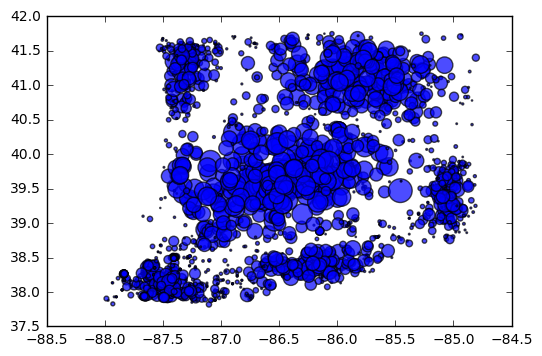

In [7]:
import matplotlib.pyplot as plt

plt.scatter(df['LON'], df['LAT'], s = df['RANGE'], alpha=0.7)
plt.show()